# Sales Forecasting

In most, not to say all, kinds of business, sales forecasting is an essential operation, since it gives a reliable estimative of the future performance of the company, allowing a better decision making process. In this project, we are going to use a [kaggle dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) with information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. We are going through the main steps in the sales forecasting process. This report  divided in 4 steps: 

* Setting up the data
* Exploratory data analysis
* Creating a baseline model
* Building the final model

## Setting up the data

Let us start by importing the main packages to be used and by loading the dataset with the orders.

In [128]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, WindowAverage, SeasonalWindowAverage, AutoARIMA, HoltWinters
from sklearn.metrics import mean_pinball_loss


path = 'data/'

df_orders = pd.read_csv(path+'olist_orders_dataset.csv')
df_orders.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00
99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00


We have 99440 observations. Now we are going to load the dataset with the orders itens information.

In [129]:
df_itens = pd.read_csv(path+'olist_order_items_dataset.csv')
df_itens.tail()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72
112649,fffe41c64501cc87c801fd61db3f6244,1,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.00,12.79


We have 112650 observations. This difference in quantity happens due to the fact that a single order can have multiple products. Now we are going to load the dataset products information. Although it is not relevant in the forecasting per say, it is useful to report the results.

In [130]:
df_products = pd.read_csv(path+'olist_products_dataset.csv')
df_products.tail()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0
32950,106392145fca363410d287a815be6de4,cama_mesa_banho,58.0,309.0,1.0,2083.0,12.0,2.0,7.0


We have 32951 observations. Now let us merge the three dataframes. Then, we will be getting only the necessary columns from each dataframe. The following columns will be chosen:

* order_id
* order_purchase_timestamp
* price
* freight_value
* product_category_name
* order_item_id

In [131]:
df = df_orders.merge(df_itens, on=['order_id'])
df = df.merge(df_products, on=['product_id'])
df = df[['order_id', 'product_id', 'order_purchase_timestamp', 'price', 'freight_value', 'product_category_name', 'order_item_id']]
df.tail()

,order_id,product_id,order_purchase_timestamp,price,freight_value,product_category_name,order_item_id
112645,e8fd20068b9f7e6ec07068bb7537f781,0df37da38a30a713453b03053d60d3f7,2017-08-10 21:21:07,356.0,18.12,esporte_lazer,1
112646,e8fd20068b9f7e6ec07068bb7537f781,0df37da38a30a713453b03053d60d3f7,2017-08-10 21:21:07,356.0,18.12,esporte_lazer,2
112647,cfa78b997e329a5295b4ee6972c02979,3d2c44374ee42b3003a470f3e937a2ea,2017-12-20 09:52:41,55.9,15.14,instrumentos_musicais,1
112648,9c5dedf39a927c1b2549525ed64a053c,ac35486adb7b02598c182c2ff2e05254,2017-03-09 09:54:05,72.0,13.08,beleza_saude,1
112649,66dea50a8b16d9b4dee7af250b4be1a5,006619bbed68b000c8ba3f8725d5409e,2018-03-08 20:57:30,68.5,18.36,beleza_saude,1


As expected, we ended up with 5 columns and 112650 rows. Now let us check the data types.

In [132]:
df.dtypes

order_id                     object
product_id                   object
order_purchase_timestamp     object
price                       float64
freight_value               float64
product_category_name        object
order_item_id                 int64
dtype: object

Let us create a date column using the order_purchase_timestamp column, since most of forecasting algorithms work with this data format. In this project we will not need the time of the purchase, so we are only getting the date. 

In [133]:
df['date'] = pd.to_datetime(df['order_purchase_timestamp']).dt.normalize()
df.tail()

,order_id,product_id,order_purchase_timestamp,price,freight_value,product_category_name,order_item_id,date
112645,e8fd20068b9f7e6ec07068bb7537f781,0df37da38a30a713453b03053d60d3f7,2017-08-10 21:21:07,356.0,18.12,esporte_lazer,1,2017-08-10
112646,e8fd20068b9f7e6ec07068bb7537f781,0df37da38a30a713453b03053d60d3f7,2017-08-10 21:21:07,356.0,18.12,esporte_lazer,2,2017-08-10
112647,cfa78b997e329a5295b4ee6972c02979,3d2c44374ee42b3003a470f3e937a2ea,2017-12-20 09:52:41,55.9,15.14,instrumentos_musicais,1,2017-12-20
112648,9c5dedf39a927c1b2549525ed64a053c,ac35486adb7b02598c182c2ff2e05254,2017-03-09 09:54:05,72.0,13.08,beleza_saude,1,2017-03-09
112649,66dea50a8b16d9b4dee7af250b4be1a5,006619bbed68b000c8ba3f8725d5409e,2018-03-08 20:57:30,68.5,18.36,beleza_saude,1,2018-03-08


Lastly, we are going to remove the data from the year 2016, since it has only a couple data points.

In [134]:
df = df.query('date>"2016-12-31"').reset_index(drop=True)
df.tail()

,order_id,product_id,order_purchase_timestamp,price,freight_value,product_category_name,order_item_id,date
112275,e8fd20068b9f7e6ec07068bb7537f781,0df37da38a30a713453b03053d60d3f7,2017-08-10 21:21:07,356.0,18.12,esporte_lazer,1,2017-08-10
112276,e8fd20068b9f7e6ec07068bb7537f781,0df37da38a30a713453b03053d60d3f7,2017-08-10 21:21:07,356.0,18.12,esporte_lazer,2,2017-08-10
112277,cfa78b997e329a5295b4ee6972c02979,3d2c44374ee42b3003a470f3e937a2ea,2017-12-20 09:52:41,55.9,15.14,instrumentos_musicais,1,2017-12-20
112278,9c5dedf39a927c1b2549525ed64a053c,ac35486adb7b02598c182c2ff2e05254,2017-03-09 09:54:05,72.0,13.08,beleza_saude,1,2017-03-09
112279,66dea50a8b16d9b4dee7af250b4be1a5,006619bbed68b000c8ba3f8725d5409e,2018-03-08 20:57:30,68.5,18.36,beleza_saude,1,2018-03-08


We ended up with 112280 rows. There are a few more steps in order to get our dataframe ready to the forecasting models required format, but let us pause here and take a deeper look into the data.

## Exploratory Data Analysis

In this part of the report, we are going to answer the following questions:

* Is there a specific period where purchases are more likely?
* Which category sells the most?
* How many itens are bought per order?

Let us start by comparing the volume of sales per month. This comparison can be done in a very straightforward way, since the dataset period ranges from 01/01/2017 to 09/03/2018. 

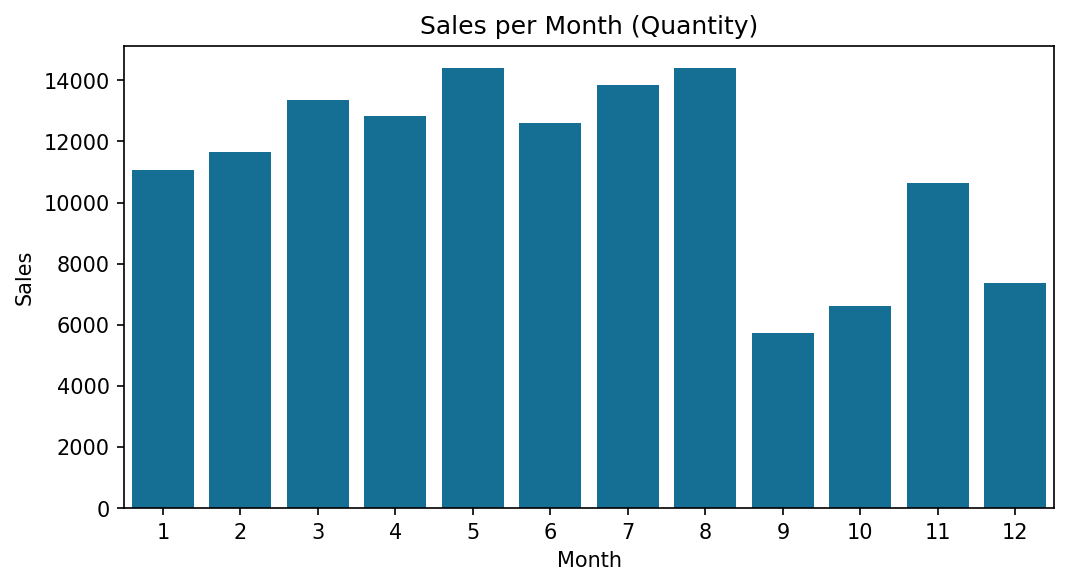

In [135]:
df_grouped_month = df[['date', 'order_item_id','price']].copy()
df_grouped_month['month'] = df_grouped_month['date'].dt.month
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
sns.barplot(data=df_grouped_month.groupby('month')['order_item_id'].sum().reset_index(), x='month', y='order_item_id', ax=ax, color='#0077AA')
ax.set_title("Sales per Month (Quantity)")
ax.set_ylabel('Sales')
ax.set_xlabel('Month')
plt.show()

The top selling months in quantity were May and August, with a number around 14000 units. September was the worst selling month, with a number close to 5000 units. Now let us see the months performance in revenue.

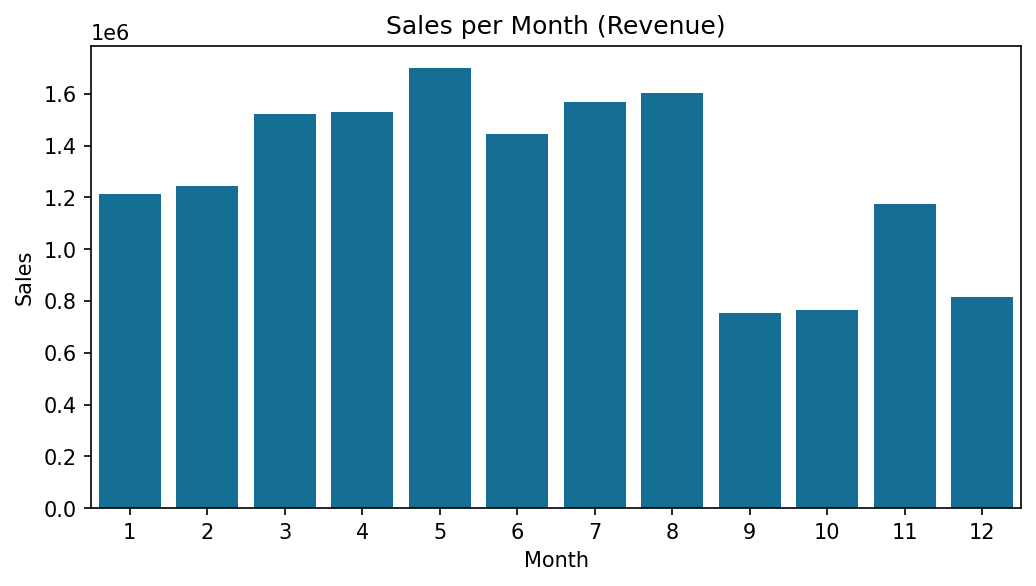

In [136]:
df_grouped_month['revenue'] = df_grouped_month['price']*df_grouped_month['order_item_id']
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
sns.barplot(data=df_grouped_month.groupby('month')['revenue'].sum().reset_index(), x='month', y='revenue', ax=ax, color='#0077AA')
ax.set_title("Sales per Month (Revenue)")
ax.set_ylabel('Sales')
ax.set_xlabel('Month')
plt.show()

The behavior is very similar, with the top selling month being May (revenue above 1.6 million) and the bottom selling month being September (revenue around 0.7 million). Now let us check the sales by category. First, we are going to see the total number of categories.

In [137]:
print("Number of categories: ", df['product_category_name'].nunique())

Number of categories:  73


Since the number of categories is too high, it is not possible to use it in a more graphical way. Let us just check the category with most a least sales by quantity and revenue.

In [138]:
df_grouped_category = df[['product_category_name', 'order_item_id', 'price']].copy()
category_quantity_max = df_grouped_category.groupby('product_category_name')['order_item_id'].sum().idxmax()
quantity_max = df_grouped_category.groupby('product_category_name')['order_item_id'].sum().max()
category_quantity_min = df_grouped_category.groupby('product_category_name')['order_item_id'].sum().idxmin()
quantity_min = df_grouped_category.groupby('product_category_name')['order_item_id'].sum().min()
print("Top selling category by quantity was {} with {} units".format(category_quantity_max, quantity_max))
print("Bottom selling category by quantity was {} with {} units".format(category_quantity_min, quantity_min))

Top selling category by quantity was cama_mesa_banho with 13649 units
Bottom selling category by quantity was seguros_e_servicos with 2 units


In [139]:
df_grouped_category['revenue'] = df_grouped_category['price']*df_grouped_category['order_item_id']
category_revenue_max = df_grouped_category.groupby('product_category_name')['revenue'].sum().idxmax()
revenue_max = df_grouped_category.groupby('product_category_name')['revenue'].sum().max()
category_revenue_min = df_grouped_category.groupby('product_category_name')['revenue'].sum().idxmin()
revenue_min = df_grouped_category.groupby('product_category_name')['revenue'].sum().min()
print("Top selling category by revenue was {} with R$ {} ".format(category_revenue_max, revenue_max))
print("Bottom selling category by revenue was {} with R$ {}".format(category_revenue_min, round(revenue_min, 2)))

Top selling category by revenue was beleza_saude with R$ 1342366.45 
Bottom selling category by revenue was seguros_e_servicos with R$ 283.29


Even though the category cama_mesa_banho sold the most units, those itens are not as expensive as the beleza_saude ones. The category seguros_e_servicos performed the worst in both scenarios. Now let us get some general information about the amount of itens per order and that will conclude our exploratory data analysis.

In [140]:
df_grouped_order = df[['order_id', 'order_item_id']].copy()
max_quantity_order = df_grouped_order.groupby('order_id').sum().max().values[0]
avg_quantity_order = df_grouped_order.groupby('order_id').sum().mean().values[0]
print("Maximum number of itens in a single order: ", max_quantity_order)
print("Average number of itens per order: ", round(avg_quantity_order, 2))

Maximum number of itens in a single order:  231
Average number of itens per order:  1.37


## Baseline Model

A baseline model is useful to better understand the forecast problem and it also gives a base performance level which has to be be surpassed by more complex models. Before we start to build our baseline model, there are a few more transformations to be performed on the data. First, we need the amount of itens sold by day for each product.

In [141]:
df_sales = df.groupby(['product_id', 'date']).agg(quantity=('order_item_id','sum')).reset_index()
df_sales.tail()

,product_id,date,quantity
94268,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-04-19,1
94269,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-05-01,1
94270,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-08-07,1
94271,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-08-10,1
94272,fffe9eeff12fcbd74a2f2b007dde0c58,2018-05-16,1


We ended up with 94591 observations. Since we have more than 30000 products, it is clear that most of the products are not sold everyday. We have to transform the data in order to consider the day with no sales as having sold a quantity zero.

In [142]:
df_pivot = df_sales.pivot(index='product_id', columns='date', values='quantity').fillna(0)
df_sales = df_pivot.stack().reset_index().rename(columns={0:'quantity'})
df_sales.tail()

,product_id,date,quantity
19770556,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-26,0.0
19770557,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-27,0.0
19770558,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-28,0.0
19770559,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-29,0.0
19770560,fffe9eeff12fcbd74a2f2b007dde0c58,2018-09-03,0.0


We ended up with more than 20 millions rows. Since the volume of  non selling days is too high, it will be more useful to consider the sales by week, instead of days. Let us group the data by week. We are going to do that by performing a cumulative counting of number of sundays since the first day in the dataset for each product.

In [143]:
df_sales['sunday'] = (df_sales['date'].dt.weekday==6)
df_sales['period'] = df_sales.groupby('product_id')['sunday'].transform('cumsum')
df_sales.tail(10)

,product_id,date,quantity,sunday,period
19770551,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-21,0.0,False,85
19770552,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-22,0.0,False,85
19770553,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-23,0.0,False,85
19770554,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-24,0.0,False,85
19770555,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-25,0.0,False,85
19770556,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-26,0.0,True,86
19770557,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-27,0.0,False,86
19770558,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-28,0.0,False,86
19770559,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-29,0.0,False,86
19770560,fffe9eeff12fcbd74a2f2b007dde0c58,2018-09-03,0.0,False,86


In [144]:
df_sales['week_start'] = df_sales.groupby(['product_id', 'period'])['date'].transform('first')
df_sales.tail(10)

,product_id,date,quantity,sunday,period,week_start
19770551,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-21,0.0,False,85,2018-08-19
19770552,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-22,0.0,False,85,2018-08-19
19770553,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-23,0.0,False,85,2018-08-19
19770554,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-24,0.0,False,85,2018-08-19
19770555,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-25,0.0,False,85,2018-08-19
19770556,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-26,0.0,True,86,2018-08-26
19770557,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-27,0.0,False,86,2018-08-26
19770558,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-28,0.0,False,86,2018-08-26
19770559,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-29,0.0,False,86,2018-08-26
19770560,fffe9eeff12fcbd74a2f2b007dde0c58,2018-09-03,0.0,False,86,2018-08-26


In [145]:
df_weekly_sales = df_sales.groupby(['product_id', 'week_start'])['quantity'].sum().reset_index()
df_weekly_sales.tail()

,product_id,week_start,quantity
2852464,fffe9eeff12fcbd74a2f2b007dde0c58,2018-07-29,0.0
2852465,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-05,0.0
2852466,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-12,0.0
2852467,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-19,0.0
2852468,fffe9eeff12fcbd74a2f2b007dde0c58,2018-08-26,0.0


We ended up with 2932639 observations. Products with really low volume of sales have a rather random behavior. Therefore, we will only be considering products that have sold at least 100 units in the whole period of the analysis. 

In [146]:
valid_products = df_weekly_sales.groupby('product_id')['quantity'].sum().reset_index().query('quantity>=100')['product_id'].unique()
df_weekly_sales = df_weekly_sales[df_weekly_sales['product_id'].isin(valid_products)].reset_index(drop=True)
df_weekly_sales.tail()

,product_id,week_start,quantity
7912,f1c7f353075ce59d8a6f3cf58f419c9c,2018-07-29,0.0
7913,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-05,0.0
7914,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-12,0.0
7915,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-19,0.0
7916,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-26,0.0


We ended up with only 7917 observations. Now we can start building our baseline model. For doing so, we are going to use the from statsforecast. A full explanation of how it works can be accessed [here](https://forecastegy.com/posts/naive-time-series-forecasting-in-python/). We are going to use the following models:

* Simple Naive Forecast
* Seasonal Naive Forecast
* Window Average Forecast
* Seasonal Window Average Forecast

In order to use the statsforecast, we have to rename our columns. Also, we will be dividing our dataset into 3 sets, training, validation and test, in order to correctly evaluate our results. In the training we will have all the data from the year of 2017. In the validation we will have the date from the first quarter of 2018. The rest will be used in the test.


In [147]:
df_weekly_sales = df_weekly_sales.rename(columns={'week_start': 'ds', 'quantity': 'y', 'product_id': 'unique_id'})
df_training = df_weekly_sales.query('ds < "2018-01-01"').copy()
df_training.tail()

,unique_id,ds,y
7878,f1c7f353075ce59d8a6f3cf58f419c9c,2017-12-03,0.0
7879,f1c7f353075ce59d8a6f3cf58f419c9c,2017-12-10,0.0
7880,f1c7f353075ce59d8a6f3cf58f419c9c,2017-12-17,0.0
7881,f1c7f353075ce59d8a6f3cf58f419c9c,2017-12-24,0.0
7882,f1c7f353075ce59d8a6f3cf58f419c9c,2017-12-31,0.0


In [148]:
df_validation = df_weekly_sales.query('(ds < "2018-04-01") & (ds >= "2018-01-01")').copy()
df_validation.tail()

,unique_id,ds,y
7890,f1c7f353075ce59d8a6f3cf58f419c9c,2018-02-25,0.0
7891,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-04,0.0
7892,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-11,0.0
7893,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-18,0.0
7894,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-25,0.0


In [149]:
df_test = df_weekly_sales.query('ds >= "2018-04-01"')
df_test.tail()

,unique_id,ds,y
7912,f1c7f353075ce59d8a6f3cf58f419c9c,2018-07-29,0.0
7913,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-05,0.0
7914,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-12,0.0
7915,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-19,0.0
7916,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-26,0.0


Now we are ready to build our model. Our forecasting horizon will be the same as the periods in the validation set. We will consider a season of 10 weeks and the window size will be equal to 4. We will be using a confidence interval of 95%.

In [150]:
h = df_validation['ds'].nunique()
model = StatsForecast(models=[Naive(), 
                              SeasonalNaive(season_length=10), 
                              WindowAverage(window_size=4), 
                              SeasonalWindowAverage(window_size=4, season_length=10)],
                      freq='W', n_jobs=-1)
model.fit(df_training)
df_baseline = model.forecast(h=h, level=[95])
df_baseline.tail()

,ds,Naive,Naive-lo-95,Naive-hi-95,SeasonalNaive,SeasonalNaive-lo-95,SeasonalNaive-hi-95,WindowAverage,SeasWA
unique_id,,,,,,,,,
f1c7f353075ce59d8a6f3cf58f419c9c,2018-02-25,0.0,-20.656656,20.656656,0.0,-25.035637,25.035637,0.0,2.50
f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-04,0.0,-21.909693,21.909693,0.0,-25.035637,25.035637,0.0,4.50
f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-11,0.0,-23.094843,23.094843,0.0,-25.035637,25.035637,0.0,3.25
f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-18,0.0,-24.222076,24.222076,0.0,-25.035637,25.035637,0.0,3.25
f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-25,0.0,-25.299133,25.299133,0.0,-25.035637,25.035637,0.0,1.50


Now, in order to make the comparison easier, let us merge the baseline dataframe with the validation one. Also, some of the models may produce a quantity below zero, since that is not possible with sales, we are going to set these values as equal to zero.

In [151]:
df_baseline.iloc[:, 1:] = df_baseline.iloc[:, 1:].clip(0)
df_validation = df_baseline.reset_index().merge(df_validation, on=['unique_id', 'ds'])
df_validation.tail()

,unique_id,ds,Naive,Naive-lo-95,Naive-hi-95,SeasonalNaive,SeasonalNaive-lo-95,SeasonalNaive-hi-95,WindowAverage,SeasWA,y
1087,f1c7f353075ce59d8a6f3cf58f419c9c,2018-02-25,0.0,0.0,20.656656,0.0,0.0,25.035637,0.0,2.50,0.0
1088,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-04,0.0,0.0,21.909693,0.0,0.0,25.035637,0.0,4.50,0.0
1089,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-11,0.0,0.0,23.094843,0.0,0.0,25.035637,0.0,3.25,0.0
1090,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-18,0.0,0.0,24.222076,0.0,0.0,25.035637,0.0,3.25,0.0
1091,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-25,0.0,0.0,25.299133,0.0,0.0,25.035637,0.0,1.50,0.0


Now we are going to see graphically how well each model performed with a single product.

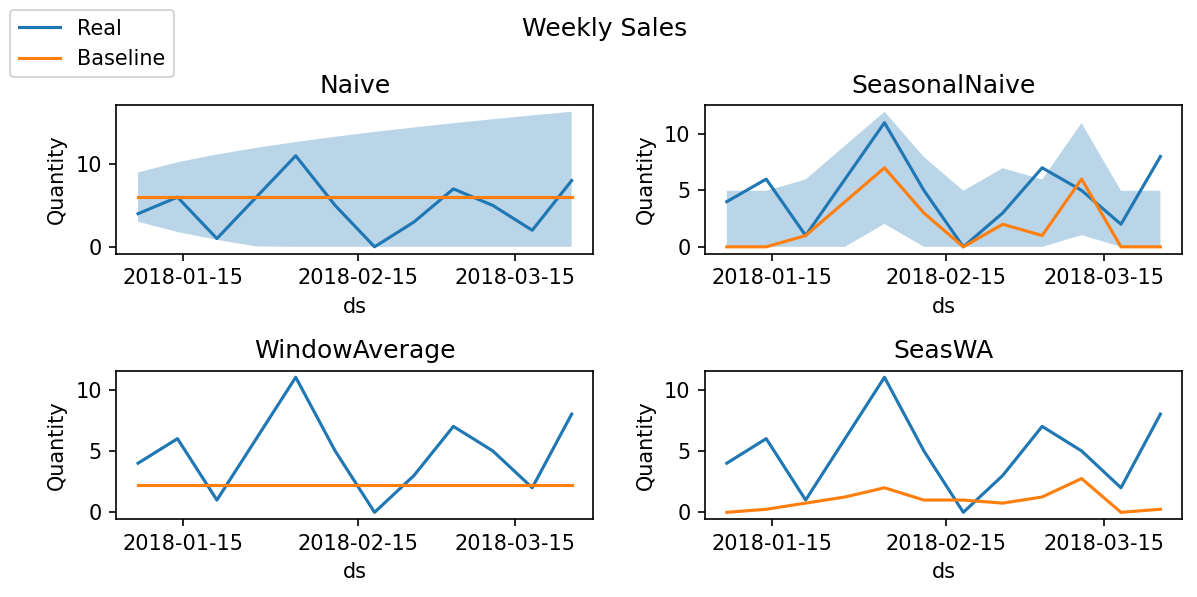

In [155]:
product = '06edb72f1e0c64b14c5b79353f7abea3'
data = df_validation.query('unique_id==@product')
fig, ax = plt.subplots(2, 2, figsize=(8, 4), dpi=150)
sns.lineplot(data=data, x='ds', y='y', ax=ax[0,0], label='Real')
sns.lineplot(data=data, x='ds', y='Naive', ax=ax[0,0], label='Baseline')
ax[0,0].fill_between(data['ds'], data['Naive-lo-95'], data['Naive-hi-95'], alpha=.3)
ax[0,0].set_title("Naive")
ax[0,0].set_xticks(['2018-01-15', '2018-02-15', '2018-03-15'])
ax[0,0].set_ylabel("Quantity")
sns.lineplot(data=data, x='ds', y='y', ax=ax[0,1])
sns.lineplot(data=data, x='ds', y='SeasonalNaive', ax=ax[0,1])
ax[0,1].fill_between(data['ds'], data['SeasonalNaive-lo-95'], data['SeasonalNaive-hi-95'], alpha=.3)
ax[0,1].set_title("SeasonalNaive")
ax[0,1].set_xticks(['2018-01-15', '2018-02-15', '2018-03-15'])
ax[0,1].set_ylabel("Quantity")
sns.lineplot(data=data, x='ds', y='y', ax=ax[1,0])
sns.lineplot(data=data, x='ds', y='WindowAverage', ax=ax[1,0])
ax[1,0].set_title("WindowAverage")
ax[1,0].set_xticks(['2018-01-15', '2018-02-15', '2018-03-15'])
ax[1,0].set_ylabel("Quantity")
sns.lineplot(data=data, x='ds', y='y', ax=ax[1,1])
sns.lineplot(data=data, x='ds', y='SeasWA', ax=ax[1,1])
ax[1,1].set_title("SeasWA")
ax[1,1].set_xticks(['2018-01-15', '2018-02-15', '2018-03-15'])
ax[1,1].set_ylabel("Quantity")
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')
ax[0,0].get_legend().remove()
plt.suptitle("Weekly Sales")
plt.tight_layout()
plt.show()

Since the volume of sales is very low, any mistake is too impactful. To evaluate our baseline models we are going to use three metrics:

* Symmetric Mean Absolute Percentage Error (SMAPE)
* Pinball Loss
* Coverage Probability

The SMAPE will give us a percentage error that can be used to compare the models. The Pinball Loss will evaluate how close we are to the real distribution of the future sales, instead of evaluating just a single point. The Coverage Probability will measure how often the sales lie within the prediction intervals. For the Pinball Loss we are going to use the sklearn package function. The others we will be declaring the functions.  

In [156]:
def smape_loss(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

def coverage_prob(y_true, y_lo, y_hi):
    return np.mean((y_lo <= y_true) & (y_true <= y_hi))

### Results - Naive

In [157]:
print("SMAPE: ", smape_loss(df_validation['y'], df_validation['Naive']))
print("Pinball Loss: ", mean_pinball_loss(df_validation['y'], df_validation['Naive-lo-95'], alpha=0.025), mean_pinball_loss(df_validation['y'], df_validation['Naive-hi-95'], alpha=0.975))
print("Coverage Probability: ",coverage_prob(df_validation['y'], df_validation['Naive-lo-95'], df_validation['Naive-hi-95']))


SMAPE:  68.98987043902746
Pinball Loss:  0.18053416457551597 1.7857413226574825
Coverage Probability:  0.8406593406593407


### Results - SeasonalNaive

In [158]:
print("SMAPE: ", smape_loss(df_validation['y'], df_validation['SeasonalNaive']))
print("Pinball Loss: ", mean_pinball_loss(df_validation['y'], df_validation['SeasonalNaive-lo-95'], alpha=0.025), mean_pinball_loss(df_validation['y'], df_validation['SeasonalNaive-hi-95'], alpha=0.975))
print("Coverage Probability: ",coverage_prob(df_validation['y'], df_validation['SeasonalNaive-lo-95'], df_validation['SeasonalNaive-hi-95']))

SMAPE:  68.96523000187145
Pinball Loss:  0.397704151469731 1.828390166428172
Coverage Probability:  0.7802197802197802


### Results - WindowAverage

In [159]:
print("SMAPE: ", smape_loss(df_validation['y'], df_validation['WindowAverage']))

SMAPE:  62.47671623182259


### Results - SeasWA

In [160]:
print("SMAPE: ", smape_loss(df_validation['y'], df_validation['SeasWA']))

SMAPE:  68.7690514733913


All the SMAPEs were too high. As we explained before, that happens because the volume of sales is very low. For instance, if a week has 1 sale and the baseline model expected 0, than the error is 100%, even though the model only got it wrong by 1 unit. The Coverage Probability were below 95% in all of applicable scenarios. Therefore, our confidence interval is not really working. The Pinball Losses were very low, but since the sales are never below zero, the upper Pinball Loss is more trustworthy.

## Final Model

To build our model, we are going to use two models:

* Autoregressive Integrated Moving Average (ARIMA)
* Holt-Winters

The ARIMA model is a linear model that combines three key components: autoregression, differencing and moving average. It is basically a combination of all the baseline models we used. The Holt-Winters models is a model specifically designed for time series data that exhibits both trend and seasonality, which is the most usual behavior for sales. 

We will use the statsforecast package implementation. It is main useful because it will apply an internal optimization process to find the best parameters for each model and product.

In [162]:
model = StatsForecast(models=[AutoARIMA(),
                              HoltWinters(season_length=4, error_type='A')],
                      freq='W', n_jobs=-1)

model.fit(df_training)
df_model = model.forecast(h=h, level=[95])
df_model.tail()

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,HoltWinters,HoltWinters-lo-95,HoltWinters-hi-95
unique_id,,,,,,,
f1c7f353075ce59d8a6f3cf58f419c9c,2018-02-25,-0.031929,-11.811539,11.747681,0.378819,-17.309359,18.066998
f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-04,-0.029954,-11.958120,11.898212,-0.887600,-19.580700,17.805502
f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-11,-0.027280,-12.080723,12.026162,-1.790613,-21.437536,17.856310
f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-18,-0.022599,-12.169497,12.124300,-0.146927,-20.703684,20.409830
f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-25,-0.020368,-12.236698,12.195961,0.476795,-20.951414,21.905005


In [163]:
df_model.iloc[:, 1:] = df_model.iloc[:, 1:].clip(0)
df_validation = df_model.reset_index().merge(df_validation, on=['unique_id', 'ds'])
df_validation.tail()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,HoltWinters,HoltWinters-lo-95,HoltWinters-hi-95,Naive,Naive-lo-95,Naive-hi-95,SeasonalNaive,SeasonalNaive-lo-95,SeasonalNaive-hi-95,WindowAverage,SeasWA,y
1087,f1c7f353075ce59d8a6f3cf58f419c9c,2018-02-25,0.0,0.0,11.747681,0.378819,0.0,18.066998,0.0,0.0,20.656656,0.0,0.0,25.035637,0.0,2.50,0.0
1088,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-04,0.0,0.0,11.898212,0.000000,0.0,17.805502,0.0,0.0,21.909693,0.0,0.0,25.035637,0.0,4.50,0.0
1089,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-11,0.0,0.0,12.026162,0.000000,0.0,17.856310,0.0,0.0,23.094843,0.0,0.0,25.035637,0.0,3.25,0.0
1090,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-18,0.0,0.0,12.124300,0.000000,0.0,20.409830,0.0,0.0,24.222076,0.0,0.0,25.035637,0.0,3.25,0.0
1091,f1c7f353075ce59d8a6f3cf58f419c9c,2018-03-25,0.0,0.0,12.195961,0.476795,0.0,21.905005,0.0,0.0,25.299133,0.0,0.0,25.035637,0.0,1.50,0.0


### Results - Holt-Winters

In [164]:
print("SMAPE: ", smape_loss(df_validation['y'], df_validation['HoltWinters']))
print("Pinball Loss: ", mean_pinball_loss(df_validation['y'], df_validation['HoltWinters-lo-95'], alpha=0.025), mean_pinball_loss(df_validation['y'], df_validation['HoltWinters-hi-95'], alpha=0.975))
print("Coverage Probability: ",coverage_prob(df_validation['y'], df_validation['HoltWinters-lo-95'], df_validation['HoltWinters-hi-95']))


SMAPE:  64.56854821755759
Pinball Loss:  0.3767336475247864 1.7697126053819512
Coverage Probability:  0.7097069597069597


### Results - ARIMA

In [165]:
print("SMAPE: ", smape_loss(df_validation['y'], df_validation['AutoARIMA']))
print("Pinball Loss: ", mean_pinball_loss(df_validation['y'], df_validation['AutoARIMA-lo-95'], alpha=0.025), mean_pinball_loss(df_validation['y'], df_validation['AutoARIMA-hi-95'], alpha=0.975))
print("Coverage Probability: ",coverage_prob(df_validation['y'], df_validation['AutoARIMA-lo-95'], df_validation['AutoARIMA-hi-95']))

SMAPE:  62.2388023671164
Pinball Loss:  0.12289243442159499 1.7597439012780187
Coverage Probability:  0.7866300366300366


The ARIMA model has an overall best result, with the lowest SMAPE and Pinball Loss and second smallest Coverage Probability. Now let us see how well it performs in the test dataset. 

In [170]:
df_training_validation = pd.concat([df_training, df_validation[['unique_id', 'ds', 'y']]], ignore_index=True)
h = df_test['unique_id'].nunique()
model = StatsForecast(models=[AutoARIMA()],
                      freq='W', n_jobs=-1)

model.fit(df_training_validation)
df_model = model.forecast(h=h, level=[95])
df_model.iloc[:, 1:] = df_model.iloc[:, 1:].clip(0)
df_test = df_model.reset_index().merge(df_test, on=['unique_id', 'ds'])
df_test.tail()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,y
1997,f1c7f353075ce59d8a6f3cf58f419c9c,2018-07-29,0.0,0.0,11.178144,0.0
1998,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-05,0.0,0.0,11.189346,0.0
1999,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-12,0.0,0.0,11.198022,0.0
2000,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-19,0.0,0.0,11.204748,0.0
2001,f1c7f353075ce59d8a6f3cf58f419c9c,2018-08-26,0.0,0.0,11.209975,0.0


### Final Results

In [171]:
print("SMAPE: ", smape_loss(df_test['y'], df_test['AutoARIMA']))
print("Pinball Loss: ", mean_pinball_loss(df_test['y'], df_test['AutoARIMA-lo-95'], alpha=0.025), mean_pinball_loss(df_test['y'], df_test['AutoARIMA-hi-95'], alpha=0.975))
print("Coverage Probability: ",coverage_prob(df_test['y'], df_test['AutoARIMA-lo-95'], df_test['AutoARIMA-hi-95']))

SMAPE:  68.12719986106629
Pinball Loss:  0.17255672575370015 0.8632229066335717
Coverage Probability:  0.8971028971028971


## Conclusion

In this project, we have built an ARIMA model that can be used in sales forecasting with a SMAPE of 68%, Pinball Loss of 0.17 (lower) and 0.86 (higher) and Coverage Probability of 0.9. The SMAPE was very high because we are mainly dealing with products with a very low sales volume (most of the products have sales as low as 1 unit per week). Also, the results could be improved if we tuned the model's parameters. For instance, we could try different season lengths.